This notebook covers the early phases of **Task 1**:  
1. Data loading & inspection  
2. Cleaning  
3. EDA & class imbalance analysis  
4. Feature engineering (initial)  
5. Handling imbalanced data  

In [48]:
# Import core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')



In [49]:
# Filepaths (update if needed)
fraud_path = "../data/raw/Fraud_Data.csv"
ip_map_path = "../data/raw/IpAddress_to_Country.csv"
credit_path = "../data/raw/creditcard.csv"

# Load
fraud_df = pd.read_csv(fraud_path)
ip_map = pd.read_csv(ip_map_path)
credit_df = pd.read_csv(credit_path)

# Show shapes
print("Fraud Data:", fraud_df.shape)
print("IP Map:", ip_map.shape)
print("Credit Card Data:", credit_df.shape)


Fraud Data: (151112, 11)
IP Map: (138846, 3)
Credit Card Data: (284807, 31)


### Basic Data Exploration

We first inspect the datasets for:
- Missing values
- Data types
- Class distribution

This gives us insight into necessary cleaning steps.


In [50]:
# Preview fraud dataset
fraud_df.head(), fraud_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


(   user_id          signup_time        purchase_time  purchase_value  \
 0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
 1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
 2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
 3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
 4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
 
        device_id source browser sex  age    ip_address  class  
 0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
 1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
 2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
 3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
 4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  ,
 None)

In [51]:
# Preview credit card data
credit_df.head(), credit_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9       V10       V11       V12       V13       V14  \
 0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
 1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
 2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
 3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
 4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   
 
         V15       V16       V17       V18      

### Missing Values & Duplicates

We detect columns with missing values and decide whether to impute or drop.


In [52]:
# Missing values
print("Fraud Missing:\n", fraud_df.isnull().sum())
print("\nCredit Card Missing:\n", credit_df.isnull().sum())

# Duplicates
print("\nFraud duplicates:", fraud_df.duplicated().sum())
print("Credit Card duplicates:", credit_df.duplicated().sum())


Fraud Missing:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Credit Card Missing:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Fraud duplicates: 0
Credit Card duplicates: 1081


### Cleaning Strategy

- Remove duplicates
- For any missing values, apply appropriate imputation where feasible


In [53]:
# Drop duplicates
fraud_df = fraud_df.drop_duplicates()
credit_df = credit_df.drop_duplicates()

# (If needed) Impute simple median for numerical missing values
num_cols = fraud_df.select_dtypes(include=['float64','int64']).columns
fraud_df[num_cols] = fraud_df[num_cols].fillna(fraud_df[num_cols].median())

print("Post-cleanup missing values:\n", fraud_df.isnull().sum())
print("Credit Card duplicates:", credit_df.duplicated().sum())


Post-cleanup missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Credit Card duplicates: 0


### Class Imbalance Analysis

Understand how imbalanced the fraud classes are for both datasets.


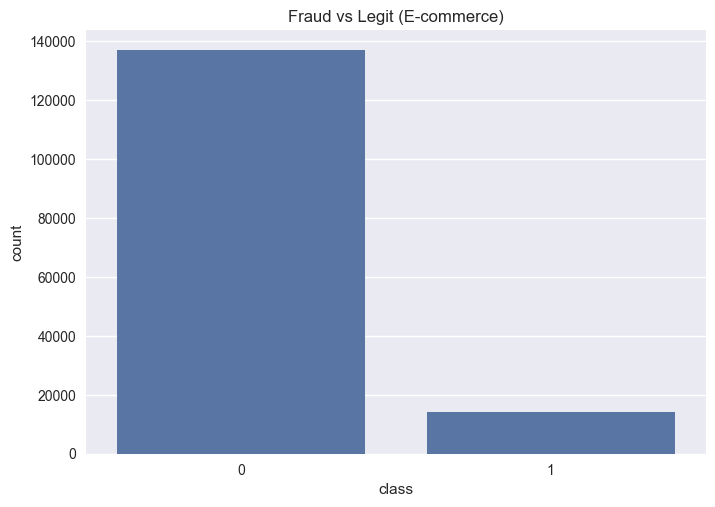

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


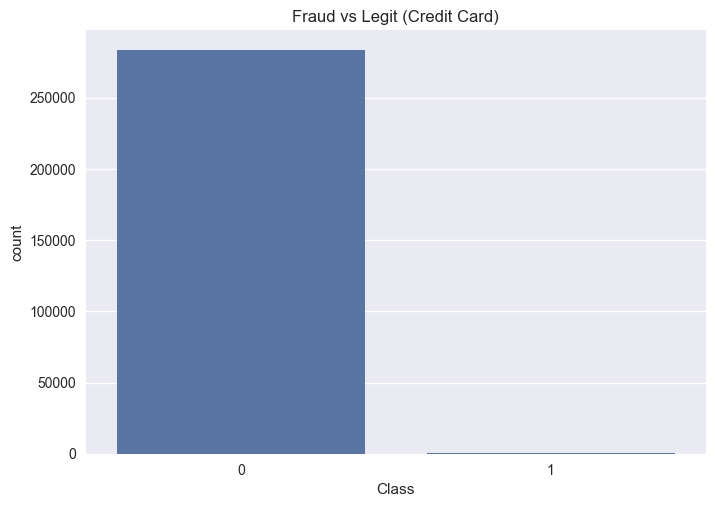

Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [54]:
# E-commerce fraud class counts
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs Legit (E-commerce)")
plt.show()

print(fraud_df['class'].value_counts(normalize=True))

# Credit card class counts
sns.countplot(x='Class', data=credit_df)
plt.title("Fraud vs Legit (Credit Card)")
plt.show()

print(credit_df['Class'].value_counts(normalize=True))


### IP Geolocation Mapping

We will:
1. Convert IP to integer
2. Merge with IP mapping
3. Analyze by country


In [55]:
import ipaddress
import numpy as np
import pandas as pd

# -------------------------------
# Convert IP to integer
# -------------------------------



def ip_to_int(x):
    return int(ipaddress.IPv4Address(x))
print('before ip to int')
print(fraud_df.head())
print(ip_map.head())
# Convert all values to strings
fraud_df['ip_address'] = fraud_df['ip_address'].astype(str)

# Keep only rows that look like IPv4: 4 parts separated by dots
fraud_df = fraud_df[
    fraud_df['ip_address'].str.count(r"\.") == 3
].copy()
# Convert all values to strings
ip_map['lower_bound_ip_address'] = ip_map['lower_bound_ip_address'].astype(str)
ip_map['upper_bound_ip_address'] = ip_map['lower_bound_ip_address'].astype(str)
# Keep only rows that look like IPv4: 4 parts separated by dots
ip_map = ip_map[
    ip_map['lower_bound_ip_address'].str.count(r"\.") == 3
].copy()
ip_map = ip_map[
    ip_map['upper_bound_ip_address'].str.count(r"\.") == 3
].copy()

# Apply conversion
fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)
ip_map['lower'] = ip_map['lower_bound_ip_address'].apply(ip_to_int)
ip_map['upper'] = ip_map['upper_bound_ip_address'].apply(ip_to_int)
print('after ip to int')
print(fraud_df[['ip_int','class']].head())
print(ip_map[['upper','country','lower']].head())
# Drop NaNs and enforce int64
fraud_df = fraud_df.dropna(subset=['ip_int'])
ip_map = ip_map.dropna(subset=['lower','upper'])
print('after drop ip to int')
print(fraud_df[['ip_int','class']].head())
print(ip_map[['upper','country','lower']].head())
fraud_df['ip_int'] = fraud_df['ip_int'].astype('int64')
ip_map['lower'] = ip_map['lower'].astype('int64')
ip_map['upper'] = ip_map['upper'].astype('int64')

# -------------------------------
# Build interval index for ranges
# -------------------------------
intervals = pd.IntervalIndex.from_arrays(ip_map['lower'], ip_map['upper'], closed='both')

def lookup_country(ip_int):
    idx = intervals.get_indexer([ip_int])[0]
    if idx == -1:
        return np.nan
    return ip_map.iloc[idx]['country']

# Map each fraud IP to its country
fraud_df['country'] = fraud_df['ip_int'].apply(lookup_country)

# -------------------------------
# Quick check
# -------------------------------


print(fraud_df[['ip_int','country','class']].head())


before ip to int
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                167